In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 30
pd.options.display.max_columns = 60

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/opgg/12일차/2021_LoL_esports_match_data_from_OraclesElixir_20211201.csv')
df = df[df['league']=='LCK'].copy()
df.reset_index(drop=True, inplace=True)
columns = list(df.columns)

In [4]:
#df.shape

In [5]:
#df.head()

In [6]:
player = df.groupby('playername', as_index=False)[['gameid']].count()
player = list(player[player['gameid'] >= 27]['playername'])

In [ ]:
df = df[df['playername'].isin(player)]
df

In [10]:
summary_df = df.copy()

summary_df['killsdiffat15'] = summary_df['killsat15'] - summary_df['opp_killsat15']
summary_df['assistsdiffat15'] = summary_df['assistsat15'] - summary_df['opp_assistsat15']
summary_df['deathsdiffat15'] = summary_df['deathsat15'] - summary_df['opp_deathsat15']
summary_df = summary_df.replace({'deaths':0}, {'deaths':1})
summary_df['KDA'] = (summary_df['kills'] + summary_df['assists'])/(summary_df['deaths'])

summary_col_list = ['playername','position',
 'golddiffat15','xpdiffat15','csdiffat15',
 'killsdiffat15','assistsdiffat15','deathsdiffat15',
 'damagetochampions','damageshare',
 'damagemitigatedperminute', 'wardsplaced','wardskilled',
 'controlwardsbought','visionscore','totalgold','total cs','monsterkills',
 'monsterkillsownjungle','monsterkillsenemyjungle','firstblood',
 'firstdragon','dragons','elders','firstherald',
 'heralds','firstbaron','barons','firsttower','towers',
 'result','KDA']

time_col_list = ['damagetochampions','damageshare',
 'damagemitigatedperminute', 'wardsplaced','wardskilled',
 'controlwardsbought','visionscore','totalgold','total cs','monsterkills',
 'monsterkillsownjungle','monsterkillsenemyjungle']

for col in time_col_list:
    summary_df[col] = summary_df[col]/summary_df['gamelength']

summary_df = summary_df[summary_col_list].copy()

In [11]:
dup_p = summary_df.groupby('playername', as_index=False)[['position']].nunique()
dup_p = dup_p[dup_p['position']>=2]
dup_p_list = list(dup_p['playername'])
dup_p_list

['Canyon', 'Kingen', 'ShowMaker', 'UmTi']

In [12]:
for player in dup_p_list:
    else_p = summary_df[summary_df['playername']==player]['position'].value_counts().keys()[1]
    index = summary_df[(summary_df['playername']==player) & (summary_df['position']==else_p)].index
    summary_df = summary_df.drop(index)

In [13]:
top_df = summary_df[summary_df['position']=='top'].copy()
top_df = top_df[['playername','KDA','total cs','damageshare','controlwardsbought','monsterkills']]
top_df = top_df.reset_index(drop=True)
top_df = top_df.dropna(axis=1)

jng_df = summary_df[summary_df['position']=='jng'].copy()
jng_df = jng_df[['playername','KDA','damageshare','total cs','damagetochampions','assistsdiffat15']]
jng_df = jng_df.reset_index(drop=True)
jng_df = jng_df.dropna(axis=1)

mid_df = summary_df[summary_df['position']=='mid'].copy()
mid_df = mid_df[['playername','KDA','total cs','damageshare','visionscore','monsterkills']]
mid_df = mid_df.reset_index(drop=True)
mid_df = mid_df.dropna(axis=1)

bot_df = summary_df[summary_df['position']=='bot'].copy()
bot_df = bot_df[['playername','KDA','total cs','damagemitigatedperminute','wardsplaced','controlwardsbought']]
bot_df = bot_df.reset_index(drop=True)
bot_df = bot_df.dropna(axis=1)

sup_df = summary_df[summary_df['position']=='sup'].copy()
sup_df = sup_df[['playername','KDA','totalgold','damageshare','golddiffat15','assistsdiffat15']]
sup_df = sup_df.reset_index(drop=True)
sup_df = sup_df.dropna(axis=1)

team_df = summary_df[summary_df['position']=='team'].copy()
team_df = team_df.drop(columns=['position'])
team_df = team_df.reset_index(drop=True)
team_df = team_df.dropna(axis=1)

In [14]:
top_player_df = top_df.groupby('playername', as_index=False).mean()
jng_player_df = jng_df.groupby('playername', as_index=False).mean()
mid_player_df = mid_df.groupby('playername', as_index=False).mean()
bot_player_df = bot_df.groupby('playername', as_index=False).mean()
sup_player_df = sup_df.groupby('playername', as_index=False).mean()

In [15]:
from sklearn.preprocessing import MinMaxScaler

def scaler(df):
    scaler = MinMaxScaler()
    df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])
    df.iloc[:,1:] = df.iloc[:,1:]*8
    df.iloc[:,1:] = df.iloc[:,1:] + 2
    return df

top_player_df = scaler(top_player_df)
mid_player_df = scaler(mid_player_df)
jng_player_df = scaler(jng_player_df)
bot_player_df = scaler(bot_player_df)
sup_player_df = scaler(sup_player_df)

In [16]:
def scoring(ddf):
    col = list(ddf.columns)
    ddf['score'] = ddf[col[1]] + ddf[col[2]] + ddf[col[3]] + ddf[col[4]] + ddf[col[5]]
    return ddf

top_player_df = scoring(top_player_df)
jng_player_df = scoring(jng_player_df)
mid_player_df = scoring(mid_player_df)
bot_player_df = scoring(bot_player_df)
sup_player_df = scoring(sup_player_df)


In [17]:
def rank(ddf):
    ddf = ddf.sort_values(by='score')
    ddf = ddf.reset_index(drop=True)
    ddf.loc[ddf['score']<=ddf['score'].quantile(0.25), 'rank'] = 'C'
    ddf.loc[(ddf['score']>ddf['score'].quantile(0.25)) & (ddf['score']<=ddf['score'].quantile(0.5)), 'rank'] = 'B'
    ddf.loc[(ddf['score']>ddf['score'].quantile(0.5)) & (ddf['score']<=ddf['score'].quantile(0.75)), 'rank'] = 'A'
    ddf.loc[(ddf['score']>ddf['score'].quantile(0.75)) & (ddf['score']<=ddf['score'].quantile(1)), 'rank'] = 'S'
    return ddf

top_player_df = rank(top_player_df)
jng_player_df = rank(jng_player_df)
mid_player_df = rank(mid_player_df)
bot_player_df = rank(bot_player_df)
sup_player_df = rank(sup_player_df)

In [18]:
top_player_df

,playername,KDA,total cs,damageshare,controlwardsbought,monsterkills,score,rank
0,Rich,5.892598,2.000000,8.074565,2.000000,2.829073,20.796235,C
1,Kingen,3.150738,5.698533,8.190631,3.579388,2.000000,22.619291,C
2,Hoya,3.852346,2.428811,5.556021,10.000000,2.335807,24.172985,C
3,Morgan,8.134588,2.980647,2.000000,8.197894,3.942677,25.255806,B
4,DuDu,4.022386,7.819122,5.821922,7.187173,6.382923,31.233527,B
5,Summit,2.000000,8.653233,10.000000,6.055026,5.112938,31.821197,B
6,Khan,10.000000,3.298034,7.548760,7.300797,6.963309,35.110900,A
7,Kiin,7.030301,9.163609,8.672647,5.777593,7.446317,38.090467,A
8,Canna,8.898019,7.657644,6.760336,6.461347,10.000000,39.777347,S
9,Doran,7.804537,9.676585,9.949603,8.098115,4.695837,40.224678,S


In [19]:
##############################################

In [20]:
def mean(ddf):
    cols = list(ddf.columns)
    ddf = ddf.append({cols[0]:'Mean',cols[1]:sum(ddf[cols[1]]),cols[2]:sum(ddf[cols[2]]),cols[3]:sum(ddf[cols[3]]),\
                     cols[4]:sum(ddf[cols[4]]), cols[5]:sum(ddf[cols[5]]), cols[6]:sum(ddf[cols[6]])}, ignore_index=True)
    ddf.iloc[-1,1:] = ddf.iloc[-1,1:]/len(ddf)
    return ddf

top_player_df = mean(top_player_df)
jng_player_df = mean(jng_player_df)
mid_player_df = mean(mid_player_df)
bot_player_df = mean(bot_player_df)
sup_player_df = mean(sup_player_df)

In [38]:
jng_player_df

,playername,KDA,damageshare,total cs,damagetochampions,assistsdiffat15,score,rank
0,GIDEON,2.000000,3.187063,5.364921,2.000000,2.000000,14.551984,C
1,Willer,6.588503,2.000000,2.891330,3.293005,5.905769,20.678608,C
2,yoHan,3.151918,5.399679,4.023256,7.394611,3.467524,23.436989,C
3,Croco,6.291200,6.201464,2.000000,5.511944,8.366160,28.370769,C
4,UmTi,6.264919,6.329937,5.868722,5.325840,5.374832,29.164250,B
5,Clid,8.711566,4.075412,3.863350,4.413021,8.336504,29.399854,B
6,Arthur,7.358504,3.610432,3.468407,5.574798,9.804477,29.816617,B
7,Blank,7.833738,4.234911,4.201907,4.960080,9.648016,30.878653,A
8,Oner,7.764223,6.628440,3.758031,6.529277,8.336504,33.016474,A
9,Pyosik,2.239283,10.000000,10.000000,9.114148,3.801972,35.155402,A


In [22]:
top_player_df[top_player_df['playername']=='Mean'][top_player_df.columns[1]]

11    5.857299
Name: KDA, dtype: float64

In [ ]:
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
 
top_list = top_player_df['playername']
jng_list = jng_player_df['playername']
mid_list = mid_player_df['playername']
bot_list = bot_player_df['playername']
sup_list = sup_player_df['playername']

lane = input("what lane?: ")
name = input("what name?: ")

lane_list = list()
if lane =='top': lane_list = top_list
elif lane=='jng': lane_list = jng_list
elif lane=='mid': lane_list = mid_list
elif lane=='bot': lane_list = bot_list
else: lane_list = sup_list

for player in lane_list:
  if player!=name: continue
  else:
    if lane=='top': 
      df = pd.DataFrame({
      'Playername': [player, 'top_mean'],
      'KDA': [top_player_df[top_player_df['playername']==player][top_player_df.columns[1]], top_player_df[top_player_df['playername']=='Mean'][top_player_df.columns[1]]],
      'Gold': [top_player_df[top_player_df['playername']==player][top_player_df.columns[2]],top_player_df[top_player_df['playername']=='Mean'][top_player_df.columns[2]]],
      'CS': [top_player_df[top_player_df['playername']==player][top_player_df.columns[3]],top_player_df[top_player_df['playername']=='Mean'][top_player_df.columns[3]]],
      'DamageShare': [top_player_df[top_player_df['playername']==player][top_player_df.columns[4]],top_player_df[top_player_df['playername']=='Mean'][top_player_df.columns[4]]],
      'mitigate dpm': [top_player_df[top_player_df['playername']==player][top_player_df.columns[5]],top_player_df[top_player_df['playername']=='Mean'][top_player_df.columns[5]]]
      })
    elif lane=='jng':
      df = pd.DataFrame({
      'Playername': [player, 'jng_mean'],
      'KDA': [jng_player_df[jng_player_df['playername']==player][jng_player_df.columns[1]],jng_player_df[jng_player_df['playername']=='Mean'][jng_player_df.columns[1]]],
      'Gold' : [jng_player_df[jng_player_df['playername']==player][jng_player_df.columns[2]],jng_player_df[jng_player_df['playername']=='Mean'][jng_player_df.columns[2]]],
      'DamageShare': [jng_player_df[jng_player_df['playername']==player][jng_player_df.columns[3]],jng_player_df[jng_player_df['playername']=='Mean'][jng_player_df.columns[3]]],
      'CS': [jng_player_df[jng_player_df['playername']==player][jng_player_df.columns[4]],jng_player_df[jng_player_df['playername']=='Mean'][jng_player_df.columns[4]]],
      'Damagetochampions': [jng_player_df[jng_player_df['playername']==player][jng_player_df.columns[5]],jng_player_df[jng_player_df['playername']=='Mean'][jng_player_df.columns[5]]]
      })
    elif lane=='mid':
      df = pd.DataFrame({
      'Playername': [player, 'mid_mean'],
      'KDA': [mid_player_df[mid_player_df['playername']==player][mid_player_df.columns[1]],mid_player_df[mid_player_df['playername']=='Mean'][mid_player_df.columns[1]]],
      'Gold': [mid_player_df[mid_player_df['playername']==player][mid_player_df.columns[2]],mid_player_df[mid_player_df['playername']=='Mean'][mid_player_df.columns[2]]],
      'CS': [mid_player_df[mid_player_df['playername']==player][mid_player_df.columns[3]],mid_player_df[mid_player_df['playername']=='Mean'][mid_player_df.columns[3]]],
      'DamageShare': [mid_player_df[mid_player_df['playername']==player][mid_player_df.columns[4]],mid_player_df[mid_player_df['playername']=='Mean'][mid_player_df.columns[4]]],
      'visionscore': [mid_player_df[mid_player_df['playername'] == player][mid_player_df.columns[5]],mid_player_df[mid_player_df['playername']=='Mean'][mid_player_df.columns[5]]]
      })
    elif lane=='bot':
      df = pd.DataFrame({
      'Playername': [player, 'bot_mean'],
      'KDA': [bot_player_df[bot_player_df['playername']==player][bot_player_df.columns[1]],bot_player_df[bot_player_df['playername']=='Mean'][bot_player_df.columns[1]]],
      'total Gold': [bot_player_df[bot_player_df['playername']==player][bot_player_df.columns[2]],bot_player_df[bot_player_df['playername']=='Mean'][bot_player_df.columns[2]]],
      'total cs': [bot_player_df[bot_player_df['playername']==player][bot_player_df.columns[3]],bot_player_df[bot_player_df['playername']=='Mean'][bot_player_df.columns[3]]],
      'physical': [bot_player_df[bot_player_df['playername']==player][bot_player_df.columns[4]],bot_player_df[bot_player_df['playername']=='Mean'][bot_player_df.columns[4]]],
      'line_presence': [bot_player_df[bot_player_df['playername']==player][bot_player_df.columns[5]],bot_player_df[bot_player_df['playername']=='Mean'][bot_player_df.columns[5]]]
      })
    else:
      df = pd.DataFrame({
      'Playername': [player, 'sup_mean'],
      'KDA': [sup_player_df[sup_player_df['playername']==player][sup_player_df.columns[1]],sup_player_df[sup_player_df['playername']=='Mean'][sup_player_df.columns[1]]],
      'Gold' : [sup_player_df[sup_player_df['playername']==player][sup_player_df.columns[2]],sup_player_df[sup_player_df['playername']=='Mean'][sup_player_df.columns[2]]],
      'DamageShare': [sup_player_df[sup_player_df['playername']==player][sup_player_df.columns[3]],sup_player_df[sup_player_df['playername']=='Mean'][sup_player_df.columns[3]]],
      'CS': [sup_player_df[sup_player_df['playername']==player][sup_player_df.columns[4]],sup_player_df[sup_player_df['playername']=='Mean'][sup_player_df.columns[4]]],
      'Damagetochampions': [sup_player_df[sup_player_df['playername']==player][sup_player_df.columns[5]],sup_player_df[sup_player_df['playername']=='Mean'][sup_player_df.columns[5]]]
      })

  labels = df.columns[1:]
  num_labels = len(labels)
    
  angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] ## 각 등분점
  angles += angles[:1] ## 시작점으로 다시 돌아와야하므로 시작점 추가
    
  my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
  fig = plt.figure(figsize=(15,20))
  fig.set_facecolor('white')
  for i, row in df.iterrows():
    color = my_palette(i)
    data = df.iloc[i].drop('Playername').tolist()
    data += data[:1]
    
    ax = plt.subplot(3,2,i+1, polar=True)
    ax.set_theta_offset(pi / 2) ## 시작점
    ax.set_theta_direction(-1) ## 그려지는 방향 시계방향
    
    plt.xticks(angles[:-1], labels, fontsize=13) ## x축 눈금 라벨
    ax.tick_params(axis='x', which='major', pad=15) ## x축과 눈금 사이에 여백을 준다.
 
    ax.set_rlabel_position(0) ## y축 각도 설정(degree 단위)
    plt.yticks([0,2,4,6,8,10],['0','2','4','6','8','10'], fontsize=10) ## y축 눈금 설정
    plt.ylim(0,10)
    
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid') ## 레이더 차트 출력
    ax.fill(angles, data, color=color, alpha=0.4) ## 도형 안쪽에 색을 채워준다.
    
    plt.title(row.Playername, size=20, color=color,x=-0.2, y=1.2, ha='left') ## 타이틀은 캐릭터 클래스로 한다.
 
  plt.tight_layout(pad=10) ## subplot간 패딩 조절
  plt.show()

what lane?: top
what name?: Canna


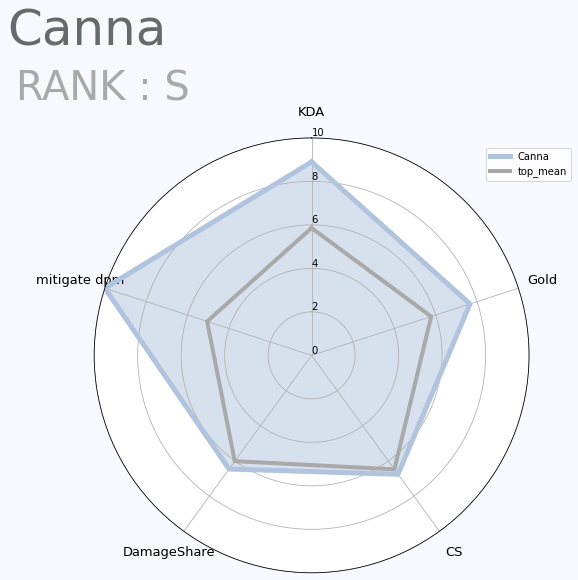

In [39]:
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
 
top_list = top_player_df['playername']
jng_list = jng_player_df['playername']
mid_list = mid_player_df['playername']
bot_list = bot_player_df['playername']
sup_list = sup_player_df['playername']

lane = input("what lane?: ")
name = input("what name?: ")

lane_list = list()
if lane =='top': lane_list = top_list
elif lane=='jng': lane_list = jng_list
elif lane=='mid': lane_list = mid_list
elif lane=='bot': lane_list = bot_list
else: lane_list = sup_list

for player in lane_list:
  if player!=name: continue
  else:
    if lane=='top': 
      df = pd.DataFrame({
      'Playername': [player, 'top_mean'],
      'KDA': [top_player_df[top_player_df['playername']==player][top_player_df.columns[1]], top_player_df[top_player_df['playername']=='Mean'][top_player_df.columns[1]]],
      'Gold': [top_player_df[top_player_df['playername']==player][top_player_df.columns[2]],top_player_df[top_player_df['playername']=='Mean'][top_player_df.columns[2]]],
      'CS': [top_player_df[top_player_df['playername']==player][top_player_df.columns[3]],top_player_df[top_player_df['playername']=='Mean'][top_player_df.columns[3]]],
      'DamageShare': [top_player_df[top_player_df['playername']==player][top_player_df.columns[4]],top_player_df[top_player_df['playername']=='Mean'][top_player_df.columns[4]]],
      'mitigate dpm': [top_player_df[top_player_df['playername']==player][top_player_df.columns[5]],top_player_df[top_player_df['playername']=='Mean'][top_player_df.columns[5]]]
      })
      rank = top_player_df[top_player_df['playername']==name]['rank'].values
    elif lane=='jng':
      df = pd.DataFrame({
      'Playername': [player, 'jng_mean'],
      'KDA': [jng_player_df[jng_player_df['playername']==player][jng_player_df.columns[1]],jng_player_df[jng_player_df['playername']=='Mean'][jng_player_df.columns[1]]],
      'Gold' : [jng_player_df[jng_player_df['playername']==player][jng_player_df.columns[2]],jng_player_df[jng_player_df['playername']=='Mean'][jng_player_df.columns[2]]],
      'DamageShare': [jng_player_df[jng_player_df['playername']==player][jng_player_df.columns[3]],jng_player_df[jng_player_df['playername']=='Mean'][jng_player_df.columns[3]]],
      'CS': [jng_player_df[jng_player_df['playername']==player][jng_player_df.columns[4]],jng_player_df[jng_player_df['playername']=='Mean'][jng_player_df.columns[4]]],
      'Damagetochampions': [jng_player_df[jng_player_df['playername']==player][jng_player_df.columns[5]],jng_player_df[jng_player_df['playername']=='Mean'][jng_player_df.columns[5]]]
      })
      rank = jng_player_df[jng_player_df['playername']==name]['rank'].values
    elif lane=='mid':
      df = pd.DataFrame({
      'Playername': [player, 'mid_mean'],
      'KDA': [mid_player_df[mid_player_df['playername']==player][mid_player_df.columns[1]],mid_player_df[mid_player_df['playername']=='Mean'][mid_player_df.columns[1]]],
      'Gold': [mid_player_df[mid_player_df['playername']==player][mid_player_df.columns[2]],mid_player_df[mid_player_df['playername']=='Mean'][mid_player_df.columns[2]]],
      'CS': [mid_player_df[mid_player_df['playername']==player][mid_player_df.columns[3]],mid_player_df[mid_player_df['playername']=='Mean'][mid_player_df.columns[3]]],
      'DamageShare': [mid_player_df[mid_player_df['playername']==player][mid_player_df.columns[4]],mid_player_df[mid_player_df['playername']=='Mean'][mid_player_df.columns[4]]],
      'visionscore': [mid_player_df[mid_player_df['playername'] == player][mid_player_df.columns[5]],mid_player_df[mid_player_df['playername']=='Mean'][mid_player_df.columns[5]]]
      })
      rank = mid_player_df[mid_player_df['playername']==name]['rank'].values
    elif lane=='bot':
      df = pd.DataFrame({
      'Playername': [player, 'bot_mean'],
      'KDA': [bot_player_df[bot_player_df['playername']==player][bot_player_df.columns[1]],bot_player_df[bot_player_df['playername']=='Mean'][bot_player_df.columns[1]]],
      'total Gold': [bot_player_df[bot_player_df['playername']==player][bot_player_df.columns[2]],bot_player_df[bot_player_df['playername']=='Mean'][bot_player_df.columns[2]]],
      'total cs': [bot_player_df[bot_player_df['playername']==player][bot_player_df.columns[3]],bot_player_df[bot_player_df['playername']=='Mean'][bot_player_df.columns[3]]],
      'physical': [bot_player_df[bot_player_df['playername']==player][bot_player_df.columns[4]],bot_player_df[bot_player_df['playername']=='Mean'][bot_player_df.columns[4]]],
      'line_presence': [bot_player_df[bot_player_df['playername']==player][bot_player_df.columns[5]],bot_player_df[bot_player_df['playername']=='Mean'][bot_player_df.columns[5]]]
      })
      rank = bot_player_df[bot_player_df['playername']==name]['rank'].values
    else:
      df = pd.DataFrame({
      'Playername': [player, 'sup_mean'],
      'KDA': [sup_player_df[sup_player_df['playername']==player][sup_player_df.columns[1]],sup_player_df[sup_player_df['playername']=='Mean'][sup_player_df.columns[1]]],
      'Gold' : [sup_player_df[sup_player_df['playername']==player][sup_player_df.columns[2]],sup_player_df[sup_player_df['playername']=='Mean'][sup_player_df.columns[2]]],
      'DamageShare': [sup_player_df[sup_player_df['playername']==player][sup_player_df.columns[3]],sup_player_df[sup_player_df['playername']=='Mean'][sup_player_df.columns[3]]],
      'CS': [sup_player_df[sup_player_df['playername']==player][sup_player_df.columns[4]],sup_player_df[sup_player_df['playername']=='Mean'][sup_player_df.columns[4]]],
      'Damagetochampions': [sup_player_df[sup_player_df['playername']==player][sup_player_df.columns[5]],sup_player_df[sup_player_df['playername']=='Mean'][sup_player_df.columns[5]]]
      })
      rank = sup_player_df[sup_player_df['playername']==name]['rank'].values

  ## 하나로 합치기
  labels = df.columns[1:]
  num_labels = len(labels)
    
  angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] ## 각 등분점
  angles += angles[:1] ## 시작점으로 다시 돌아와야하므로 시작점 추가
    
  my_palette = ['lightsteelblue', '#696969']
 
  fig = plt.figure(figsize=(8,8))
  fig.set_facecolor('white')
  ax = fig.add_subplot(polar=True)
  for i, row in df.iterrows():
    color = my_palette[i]
    data = df.iloc[i].drop('Playername').tolist()
    data += data[:1]
    
    ax.set_theta_offset(pi / 2) ## 시작점
    ax.set_theta_direction(-1) ## 그려지는 방향 시계방향
    
    plt.xticks(angles[:-1], labels, fontsize=13) ## 각도 축 눈금 라벨
    ax.tick_params(axis='x', which='major', pad=15) ## 각 축과 눈금 사이에 여백을 준다.
 
    ax.set_rlabel_position(0) ## 반지름 축 눈금 라벨 각도 설정(degree 단위)
    plt.yticks([0,2,4,6,8,10],['0','2','4','6','8','10'], fontsize=10) ## 반지름 축 눈금 설정
    plt.ylim(0,10)

    if i==0:
      name = row.Playername
      ax.plot(angles, data, color=color, linewidth=5, linestyle='solid', label=row.Playername) ## 레이더 차트 출력
      ax.fill(angles, data, color=color, alpha=0.5) ## 도형 안쪽에 색을 채워준다.
    else:
      ax.plot(angles, data, color='darkgray', linewidth=4, linestyle='solid', label=row.Playername)

fig.set_facecolor('ghostwhite')
plt.title(name, size=20, color=color, x=-0.2, y=1.2, ha='left', fontsize=50)
plt.legend(loc=(0.9,0.9))
plt.suptitle('RANK : ' + list(rank)[0], size=20, color='darkgray',x=0, y=1.0, ha='left', fontsize=40)
plt.show()

In [ ]:
jb